# Group 24 Project Proposal
Jessica Liu, April Cao, An Zhou, Nathan Lee

## Introduction
This dataset is a user knowledge model created by a novel  “Intuitive Knowledge Classifier” method. This method takes the distances among the students’ optimum weight value of different features on their knowledge class and determines students’ knowledge class by dissimilarities in the process. (Kahraman, 2012) In this project, we are going to predict a numeric value of exam performance (PEG) using the degree of study time, the degree of repetition number of the user, the degree of study time of related objects of the user, and the related objects exam performance of the user (SCG, STG, STR, and LPR respectively). The data set we are using is in the form of an excel sheet. It contains 5 numerical values (SCG, STG, STR, LPR and PEG) and one categorical value (UNS).

## Methods & Results
Firstly, the excel sheet was read and tidied by selecting the relevant columns. After using `head()` to get a better look at the data and `describe()`, from the `psych` package, to summarize it, four scatter plots were generated to visualize the relationship between our response variable, PEG, and one out of four of our predictors. The predictors were chosen based on the expected relationship between them and the response variable, PEG. It was predicted that STG (figure 1), SCG (figure 2), or STR (figure 3) will form a positive relationship with PEG, but that LPR (figure 4) will form a negative relationship with PEG. After observing the plots and discovering there were no correlations with any of the predictors with PEG individually, a predictive model was created based on all four predictors and the response variable. A more in depth explanation of the reasoning can be found in the discussion.

First, a model specification was created and the optimal K value was found using `nearest_neighbors()` and `tune()`. Then, the recipe was specified and the predictors were scaled to preprocess our data. A 5-fold cross-validation was then performed to choose the K and collected the metrics from the workflow. The model was then retrained on the entire training data using the optimal K value and the RMSPE value was determined. Next, three new observations were created by using the `tibble()` functions, and tested them one by one using the KNN regression predictive model to analyze the results. 

In [1]:
#installing packages
# install.packages("tidymodels")
# install.packages("readxl")
# install.packages("repr")
# install.packages("tidyverse")
# install.packages("psych")
# install.packages("digest")
# install.packages("kknn")

In [2]:
#libraries
library(psych)
library(tidyverse)
library(repr)
library(tidymodels)
library(readxl)
library(digest)
library(kknn)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ ggplot2::%+%()   masks psych::%+%()
✖ ggplot2::alpha() masks psych::alpha()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 0.2.0 ──

✔ broom        0.7.12     ✔ rsample      0.1.1 
✔ dials        0.1.1      ✔ tune         0.2.0 
✔ infer        1.0.0      ✔ workflows    0.2.6 
✔ modeldata    0.1.1      ✔ workflowsets 0.2.1 
✔ parsnip      0.2.1      ✔ yardstick    1.0.0 
✔ recipes      0.2.0      

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖

In [3]:
#loading in data
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls"
download.file(url, "uk_data.xls")

uk_train <- read_excel("uk_data.xls", sheet = 2)
uk_train <- uk_train %>%
    select(STG:UNS)

uk_test <- read_excel("uk_data.xls", sheet = 3)
uk_test <- uk_test %>%
    select(STG:UNS)

New names:
• `` -> `...7`
• `` -> `...8`
New names:
• `` -> `...7`
• `` -> `...8`


In [4]:
set.seed(2022) 

head(uk_train)
head(uk_test)

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.10,0.50,0.26,0.05,Very Low
0.05,0.05,0.55,0.60,0.14,Low
0.08,0.18,0.63,0.60,0.85,High
0.20,0.20,0.68,0.67,0.85,High
0.22,0.22,0.90,0.30,0.90,High
0.14,0.14,0.70,0.50,0.30,Low


In [5]:
#summary table
#via https://www.statology.org/summary-table-in-r/#:~:text=The%20easiest%20way%20to%20create%20summary%20tables%20in%20R%20is,functions%20from%20the%20psych%20library.
uk_train_summary <- describe(uk_train)
uk_train_summary

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
STG,1,258,0.3711473,0.2102712,0.3270,0.3573365,0.2001510,0,0.99,0.99,0.54530383,-0.2805904,0.01309091
SCG,2,258,0.3556744,0.2119623,0.3025,0.3412452,0.1816185,0,0.90,0.90,0.60233875,-0.3902010,0.01319620
STR,3,258,0.4680039,0.2459398,0.4900,0.4706971,0.2965200,0,0.95,0.95,-0.05328495,-1.0798002,0.01531154
LPR,4,258,0.4327132,0.2481080,0.3300,0.4224519,0.2372160,0,0.99,0.99,0.39616700,-1.0173734,0.01544653
PEG,5,258,0.4585388,0.2552109,0.5000,0.4558798,0.3261720,0,0.93,0.93,0.07280595,-1.2570042,0.01588874
UNS*,6,258,2.2829457,0.9384667,2.0000,2.2355769,1.4826000,1,4.00,3.00,0.08922054,-0.9857867,0.05842638


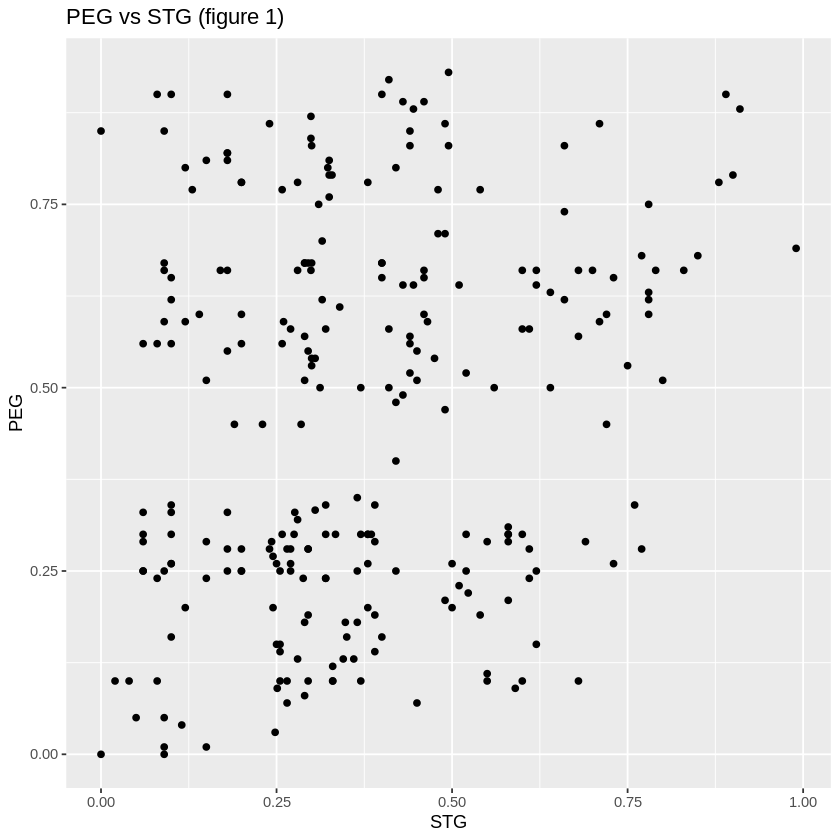

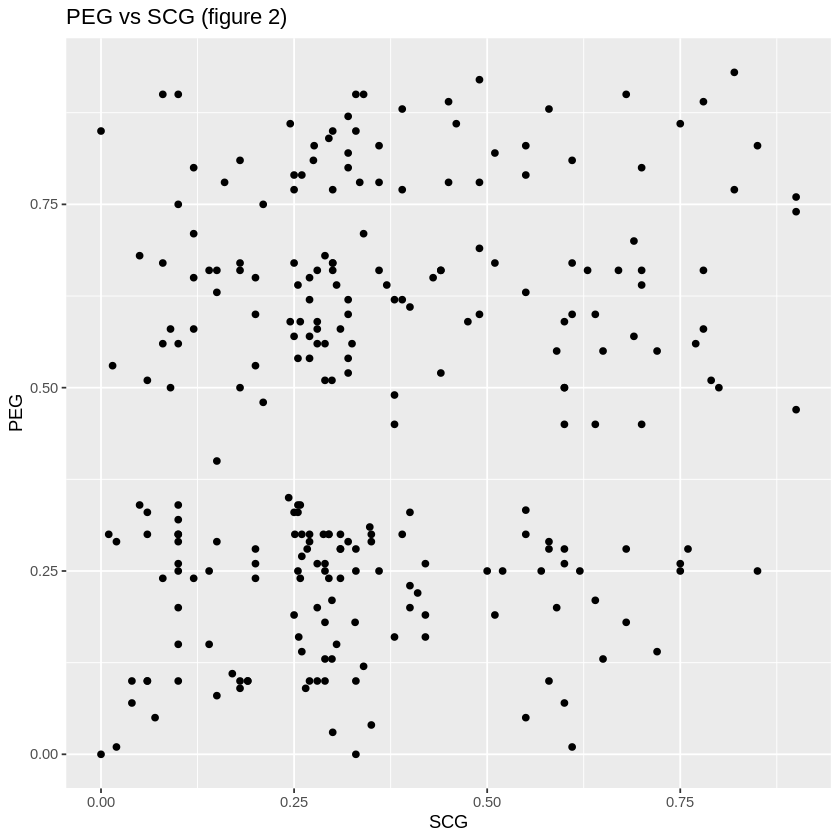

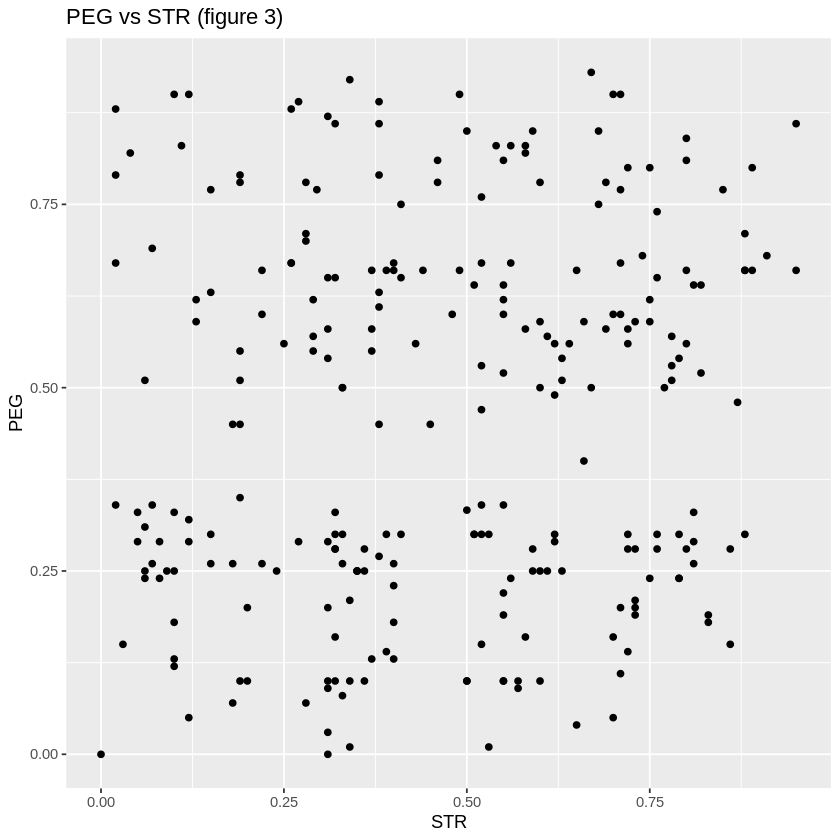

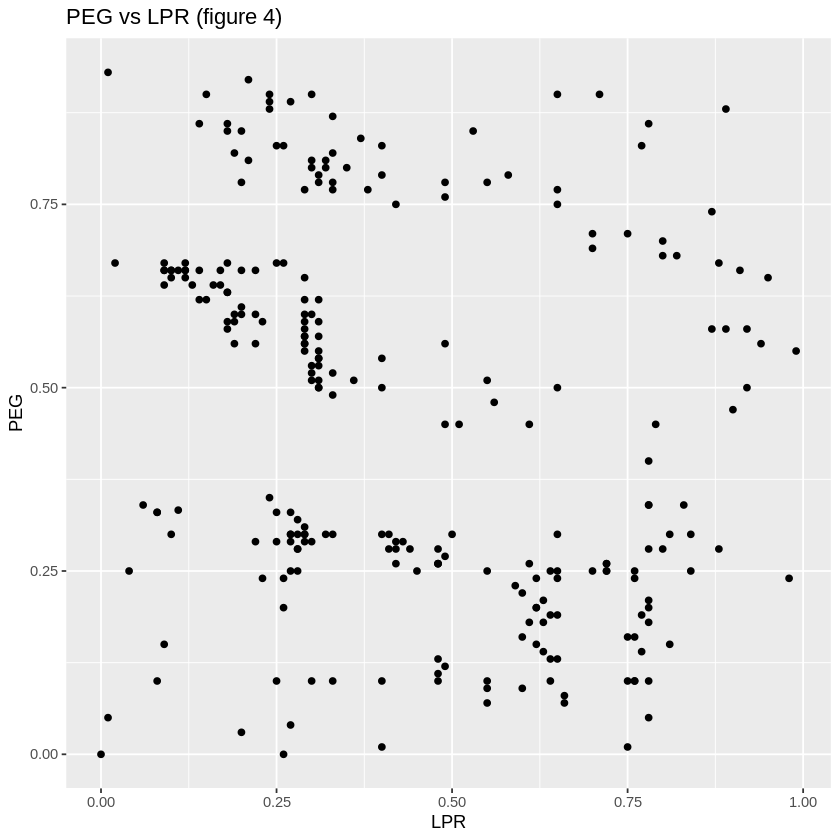

In [6]:
# plots (response variable vs. predictor)
stgpeg_plot <- uk_train %>%
    ggplot(aes(x = STG, y = PEG)) +
    geom_point() +
    ggtitle("PEG vs STG (figure 1)")
stgpeg_plot

scgpeg_plot <- uk_train %>%
    ggplot(aes(x = SCG, y = PEG)) +
    geom_point()+
    ggtitle("PEG vs SCG (figure 2)")
scgpeg_plot

strpeg_plot <- uk_train %>%
    ggplot(aes(x = STR, y = PEG)) +
    geom_point()+
    ggtitle("PEG vs STR (figure 3)")
strpeg_plot

lprpeg_plot <- uk_train %>%
    ggplot(aes(x = LPR, y = PEG)) +
    geom_point()+
    ggtitle("PEG vs LPR (figure 4)")
lprpeg_plot

In [7]:
set.seed(2022)

# create model specification
uk_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
       set_engine("kknn") %>%
       set_mode("regression") 
uk_spec

# create the recipe
uk_recipe <- recipe(PEG ~ STG + SCG + STR + LPR, data = uk_train) %>%
       step_scale(all_predictors()) %>%
       step_center(all_predictors())
uk_recipe

K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In [8]:
set.seed(2022)

# cross-validation
uk_vfold <- vfold_cv(uk_train, v = 5, strata = PEG)

gridvals <- tibble(neighbors = seq(1, 80))
head(gridvals)

uk_workflow <- workflow() %>%
    add_recipe(uk_recipe) %>%
    add_model(uk_spec)%>%
    tune_grid(resamples = uk_vfold, grid = gridvals) %>%
    collect_metrics()

head(uk_workflow)

neighbors
<int>
1
2
3
4
5
6


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,0.30392470,5,0.012155357,Preprocessor1_Model01
1,rsq,standard,0.09153449,5,0.032412251,Preprocessor1_Model01
2,rmse,standard,0.27133270,5,0.014390760,Preprocessor1_Model02
2,rsq,standard,0.10053545,5,0.049822477,Preprocessor1_Model02
3,rmse,standard,0.25731379,5,0.009967913,Preprocessor1_Model03
3,rsq,standard,0.10900564,5,0.035109458,Preprocessor1_Model03


In [9]:
set.seed(2022)

# find k parameter with smallest rmse
uk_min <- uk_workflow %>%
    filter(.metric == "rmse") %>%
    arrange(mean) %>% 
    slice(1) %>%
    pull(neighbors)

uk_min

uk_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = uk_min) %>%
          set_engine("kknn") %>%
          set_mode("regression")

uk_best_fit <- workflow() %>%
          add_recipe(uk_recipe) %>%
          add_model(uk_best_spec) %>%
          fit(data = uk_train)

uk_summary <- uk_best_fit %>%
           predict(uk_test) %>%
           bind_cols(uk_test) %>%
           metrics(truth = PEG, estimate = .pred)
uk_summary

[1] 17

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.31882629
rsq,standard,0.01237301
mae,standard,0.26965030


In [10]:
set.seed(2022)

# predictions
new_obv_1 <- tibble(STG = 0.89, SCG = 0.78, STR = 0.91, LPR = 0.12)
new_obv_pre_1 <- uk_best_fit %>%
           predict(new_obv_1)
new_obv_pre_1 #expected to be higher than average


new_obv_2 <- tibble(STG = 0.19, SCG = 0.04, STR = 0.21, LPR = 0.89)
new_obv_pre_2 <- uk_best_fit %>%
           predict(new_obv_2)
new_obv_pre_2 #expected to be lower than average
 

new_obv_3 <- tibble(STG = 0.32, SCG = 0.38, STR = 0.47, LPR = 0.50)
new_obv_pre_3 <- uk_best_fit %>%
           predict(new_obv_3)
new_obv_pre_3 #expected to be average

.pred
<dbl>
0.6447059


.pred
<dbl>
0.2341176


.pred
<dbl>
0.4282353


## Discussion

$Summary$

By using a series of plots comparing the response variable PEG to each of the four predictors (STG, SCG, STR, and LPR) individually, a conclusion that there were no significant relationships in the data was reached. As seen in figures 1 through 4, the even distribution of points across the graphs suggests a correlation of zero for each comparison.
 
Although each of the predictors had no correlation with the response variable (PEG) individually, there may be a relationship between PEG and the four predictors simultaneously that cannot be visualized. This was tested by making and using a KNN regression algorithm to predict new PEG values from several new observations. The directionality of the STG, SCG, STR, and LPR values for the new observations were chosen based on our hypothesis about the relationships between PEG and each of the predictors. The numerical values were chosen in relation to the means of each predictor ($M_{STG}$ = 0.38, $SD_{STG}$ = 0.22, $M_{SCG}$ = 0.36, $SD_{SCG}$ = 0.22, $M_{STR}$ = 0.46, $SD_{SPR}$ = 0.25, $M_{LPR}$ = 0.42, $SD_{LPR}$ = 0.25) as seen in the summary table.
 
Summary of each observation:

Observation 1: Above average STG, SCG, and STR values (0.89, 0.78, and 0.91 respectively) and a below average LPR value (0.12) were chosen with the expectation that the KNN regression algorithm will predict a higher-than-average PEG value. Our expectation was weakly supported as the algorithm predicted a PEG value of 0.64, which is 0.69 standard deviations ($z$ = 0.69) from the mean ($M_{PEG}$ = 0.46, $SD_{PEG}$ = 0.26).

Observation 2: Below average STG, SCG, and STR values (0.19, 0.04, and 0.21 respectively) and an above average LPR value (0.89) were chosen with the expectation that the KNN regression algorithm will predict a lower-than-average PEG value. Our expectations were once again weakly supported as the algorithm predicted a PEG value of 0.23, which is -0.88 standard deviations ($z$ = -0.88) from the mean ($M_{PEG}$ = 0.46, $SD_{PEG}$ = 0.26).

Observation 3: Average STG, SCG, STR, and LPR values (0.32, 0.38, 0.47, and 0.50 respectively) were chosen with the expectation that the KNN regression algorithm will predict a just-average PEG value. Our expectations were supported as the algorithm predicted a PEG value of 0.43, which is only -0.12 standard deviations ($z$ = -0.12) from the mean ($M_{PEG}$ = 0.46, $SD_{PEG}$ = 0.26).
 
Although the results correlate with the hypothesis, the prediction error is high in the KNN regression algorithm as RMSPE indicated a ± 0.23 prediction error. Since the PEG points range from 0.00 to 1.00, this error is detrimental to the accuracy of the values we can predict, deeming it unreliable.


$Expectations$

A negative linear relationship between PEG and LPR, and a positive linear relationship between PEG and the three predictor variables STG, SCG, and STR individually are expected to be found. As students spend more time studying the goal object materials (STG), related material (STR), or having repetitive exposure to the goal object material (SCG), they will perform better on the object goals exam (PEG). However, they may not perform well on both exams simultaneously. Therefore, if the exam performance of user for the related object is high, then the user may not perform as well on the exam of goal objects, and vice versa.
 
However, as can be seen from figures 1-4, PEG against four predictors individually shows no correlation between any of the comparisons. These observations are completely different from what we expected. This data suggests that no matter how long students study for goal object materials and related material, how many times students repeat the same goal object materials, or how well they perform on the exam about a related object may not correlate with their performance on the goal objects' exam. There may be students who spent a lot of time studying and had repetitive exposure to the goal object material, but still got a non-ideal mark on the exam, while some others seemed to spend little time on the material, but performed well on the =goal object exam. Additionally, there are also students who performed well on both exams, while others who failed both. Hence, there is no correlation between the four predictors and the response variable.
 
This may be because there are many other external factors that also affect exam performance, such as concentration, carefulness, and mentality. If the student has low concentration, they may not be able to focus on the exam for long periods of time, leading to fatigue and mistakes. If students are not careful during the exam, reading the questions carefully, misunderstanding the questions, or making other small mistakes, their grades could also be unsatisfactory. Attitude also plays an important role in exam performance. If students feel too nervous during the exam, they may feel very uncomfortable, shiver, and have no way to perform well on the exam (Machucho, 2018). These are all factors that could affect the performance of the exam but are not mentioned in the data set. Therefore, our data is not comprehensive enough to make the desired observations.


$Impact$

From the results of figures 1-4, there were no visible relationships in any of the plots. Therefore, these findings present no impact on answering any future predictive questions regarding one of the four predictors and the response variable. It would be inaccurate to conclude that the PEG value could be predicted if any one of the predictors were changed because there are no strong correlations between PEG and the predictors. The goal of the four plots was to determine if study time or repetition number of object goals and related objects would have the highest influence on exam performance. Therefore, it would be more impactful if one of the plots revealed a strong relationship so individuals could find the optimal study strategy to improve their exam performance.
 
The predictive model involving all four predictors and PEG showed some relationship and matched our expectations. However, the findings had an RMSPE value of ±0.23 and the results should be taken in with little consideration. Given that high STG, SCG, STR values (0.89, 0.78, 0.91 respectively) and low LPR values (0.12) resulted in an above average PEG, students may cautiously conclude that increasing study time and repetition number for goal objects and increasing study time for related objects will improve their exam performance on electrical DC machines. On the other hand, reversing the values by using low STG, SCG, STR values (0.19, 0.04, 0.21, respectively) and high LPR values (0.89) resulted in an expected lower than average PEG value. These findings provided evidence of the weak, yet visible effect of STG, SCG, and STR on exam performance. It is significant to recognize that all three studying strategies must be used to improve exam performance of goal objects. The third, newly created observation consists of intermediate values for all four predictors. After entering the new tibble into the predictive model, it generated an average PEG value which was consistent with our expectations. Although our model supported our predictions, the high prediction error makes it hard to conclude if the prediction model was impactful. Due to the predictive model’s high standard deviation, students should not confidently estimate their PEG value based on their STG, SCG, STR, and LPR.


$Future \: Questions$

Given the results discussed above, the four variables do not affect PEG in this case. To find out what truly affects PEG, more data should be taken into analysis. For instance, some users may just be good at taking exams, but do not study a lot for them. By adding another predictor that evaluates users’ performance on an unrelated exam that they did not study for will give insight on their exam-taking abilities. The mental and physical status of users can also be taken into consideration. This includes users’ attitudes towards the exam and whether they feel physically comfortable during it. Such data can be collected via a self-report survey after the exam.
 
Additionally, a different sample of users can be examined to see whether different user groups result in similar data and correlation between the variables.The users may also be divided into different age groups and levels of education to observe if the users’ background influences the correlation between the variables. To analyze it, a new categorical column can be added to distinguish users of different backgrounds.
 
Another idea for testing the model is to change the goal object. There exists a possibility that the goal object exam of the electrical DC machines is too difficult or easy, and therefore makes the degree of study to have less influence on the results. If the exam is inherently difficult, then a lot of users may have low scores despite the amount of time and effort spent studying, and vice versa. In this case, goal objects exam can be divided into different levels based on difficulties and observe the correlation between variables in each level. Similar to user background, a new categorical column can be added to analyze this part of the data.

Finally, although the individual predictors chosen had no impact on how to improve exam performance, the results may differ for topics other than electrical DC machines. For example, repetition for goal objects may not have a relationship with exam performance of electrical DC machines, but it will have a positive impact on student achievement in biopsychology courses (Janes, 2020).

## Citations
Janes, J. L., Dunlosky, J., Rawson, K. A., &amp; Jasnow, A. (2020). Successive relearning improves performance on a high‐stakes exam in a difficult biopsychology course. Applied Cognitive Psychology, 34(5), 1118–1132. https://doi.org/10.1002/acp.3699 

Machucho, Megan. “Factors That Affect Students' Test Scores.” Owlcation, Owlcation, 13 May 2018, https://owlcation.com/academia/Factors-That-Affect-Students-Test-Scores

Kahraman, H. T., Sagiroglu, S., &amp; Colak, I. (2012, August 21). The development of intuitive knowledge classifier and the modeling of Domain Dependent Data. Knowledge-Based Systems. Retrieved June 11, 2022, from https://www.sciencedirect.com/science/article/abs/pii/S0950705112002225 